In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langchain_community langchain-ollama

In [2]:
%%capture --no-stderr
%pip install langfuse langchain --upgrade

In [3]:
import os, getpass

def _set_env(var: str):
    os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("LANGFUSE_PUBLIC_KEY")
_set_env("LANGFUSE_SECRET_KEY")

LANGFUSE_PUBLIC_KEY:  ········
LANGFUSE_SECRET_KEY:  ········


In [4]:
from langfuse import Langfuse
from langfuse.callback import CallbackHandler

# Initialize Langfuse client
langfuse = Langfuse(
    public_key=os.getenv("LANGFUSE_PUBLIC_KEY"),
    secret_key=os.getenv("LANGFUSE_SECRET_KEY"),
    host="http://localhost:3000"
)

langfuse_handler = CallbackHandler(
    public_key=os.getenv("LANGFUSE_PUBLIC_KEY"),
    secret_key=os.getenv("LANGFUSE_SECRET_KEY"),
    host="http://localhost:3000"
)

In [5]:
from langchain_ollama import ChatOllama

ollama_model = ChatOllama(
    model="llama3.1",
    temperature=0
)

In [6]:
from langchain_core.prompts import ChatPromptTemplate

# Now we are using ChatPromptTemplate instead of PromptTemplate
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant that translates {input_language} to {output_language}.",
        ),
        ("human", "{input}"),
    ]
)

chain = prompt | ollama_model
chain.invoke(
    {
        "input_language": "English",
        "output_language": "Spanish",
        "input": "Where is my llama?.",
    },
    config={"callbacks": [langfuse_handler]}
)

AIMessage(content='¿Dónde está mi llama? (Where is my llama?)', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-10-15T01:26:34.295075Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 8184361792, 'load_duration': 7609508833, 'prompt_eval_count': 31, 'prompt_eval_duration': 149471000, 'eval_count': 15, 'eval_duration': 421245000}, id='run-55d44a28-6895-4153-95ee-0e631f181a82-0', usage_metadata={'input_tokens': 31, 'output_tokens': 15, 'total_tokens': 46})

Now lets try to muliply 2 numbers

In [8]:
multiply_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant that multiplies 2 numbers, the user is going to provide 2 numbers and you have to muliply them.",
        ),
        ("human", "{input}"),
    ]
)

multiply_chain = multiply_prompt | ollama_model
multiply_chain.invoke(
    {
        "input": "5674356 and 43526789",
    },
    config={"callbacks": [langfuse_handler]}
)

AIMessage(content="To multiply these two numbers, I'll perform the calculation:\n\n5674356 × 43526789 = \n\nCalculating...\n\nThe result is: **246,911,111,444**\n\nLet me know if you need any further assistance!", additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-10-15T01:29:49.828817Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 2363333500, 'load_duration': 29677083, 'prompt_eval_count': 53, 'prompt_eval_duration': 891677000, 'eval_count': 49, 'eval_duration': 1438450000}, id='run-57bdf0a1-3d0d-49ee-b59c-33997247233f-0', usage_metadata={'input_tokens': 53, 'output_tokens': 49, 'total_tokens': 102})

In [9]:
5674356 * 43526789

246986496322884

Oh no! My llama does not work really well at multiplying numbers.

So let's bring some arithmetical tools to my llama chain so the model can use it by demand

## Function calling

In [21]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

my_tools = [multiply]
ollama_with_tools = ollama_model.bind_tools(my_tools)
tool_node = ToolNode(my_tools)

ToolNode operates on graph state with a list of messages. 
It expects the last message in the list to be an **AIMessage** with **tool_calls** parameter.

**Let's first see how to invoke the tool node manually:**

In [23]:
from langchain_core.messages import AIMessage
message_with_a_tool_call = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "multiply",
            "args": {"a": 20, "b": 5},
            "id": "tool_call_id",
            "type": "tool_call",
        }
    ],
)

tool_node.invoke({"messages": [message_with_a_tool_call]})

{'messages': [ToolMessage(content='100', name='multiply', tool_call_id='tool_call_id')]}

We got the result as the content, and it is correct. Note we are not using any model, just calling the tool manually

In [12]:
from langchain_core.messages import HumanMessage

tool_call = ollama_with_tools.invoke(
    [HumanMessage(content=f"What is 2 multiplied by 3", name="JuanPulido")], 
    config={"callbacks": [langfuse_handler]}
    )
tool_call

AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-10-15T01:32:17.886753Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'multiply', 'arguments': {'a': 2, 'b': 3}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 2177728625, 'load_duration': 31231000, 'prompt_eval_count': 174, 'prompt_eval_duration': 1513143000, 'eval_count': 22, 'eval_duration': 632297000}, id='run-00db1804-795a-4f54-99ed-8ce7abd16863-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'c0500bfb-21d0-421a-b774-39877154a578', 'type': 'tool_call'}], usage_metadata={'input_tokens': 174, 'output_tokens': 22, 'total_tokens': 196})

Note in LangFuse that this is not a RunnableSequence but a ChatOLlama instead, this because we are not chaining a prompt and a model, but we just added some tools to the model and just invoke it.

In this case, in the invoke output we can see the **tool_calls** field which contains the function calling to our previous defined **multiply** python function.

As we are not using the tool_node to run manually the function we cannot get the result. But lets do it

In [24]:
tool_node.invoke({"messages": [tool_call]})

{'messages': [ToolMessage(content='6', name='multiply', tool_call_id='c0500bfb-21d0-421a-b774-39877154a578')]}

### Putting the function calling in a Graph

Now we saw some of the functionalities when using Sequences and chains in LangChain, but if we want to build a product-ready app, we will need something more than just **Micro-Orchestration** but **Macro-Orchestation**, and there is when LangGraph comes to play.

Let's build a simple Graph using our previously Ollama model + tools

Note that here our main Node to be defined is the invocation of our ollama model passing as input the messages state from LangGraph State

In [14]:
%%capture --no-stderr
%pip install -U langgraph

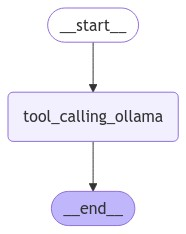

In [15]:
from langgraph.graph import MessagesState, StateGraph, START, END
from IPython.display import Image, display

# Node definition
def tool_calling_ollama(state: MessagesState):
    return {
        "messages": [
            ollama_with_tools.invoke(
                state["messages"], 
                config={
                            "callbacks": [langfuse_handler]
                       }
                )
        ]
    }

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_ollama", tool_calling_ollama)
builder.add_edge(START, "tool_calling_ollama")
builder.add_edge("tool_calling_ollama", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

As we can see, we only defined the graph, but we didnt invoke the whole application, it is just a simple graph with a start a central node and an end

## Now let's invoke the Graph

In [16]:
# the function is not being called
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================
Tool Calls:
  None (959f1a60-b9a2-406d-b0e9-17e048efa4e8)
 Call ID: 959f1a60-b9a2-406d-b0e9-17e048efa4e8
  Args:


As you can suppose here, llama model is smart and it detects that no function call is needed here, thats why the tool calls is None.

As a homework for the reader, investigate why both generations are being attached in the same trace (LangFuse)

## Lets use a message that makes llama call the function

In [17]:
messages = graph.invoke(
    {
        "messages": HumanMessage(content="I would like to know how much is 5674356 by 43526789")
    },
    config={
            "callbacks": [langfuse_handler]
        })
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

I would like to know how much is 5674356 by 43526789
================================== Ai Message ==================================
Tool Calls:
  multiply (545ddc4b-75f6-4175-ab05-a34c1dcf6096)
 Call ID: 545ddc4b-75f6-4175-ab05-a34c1dcf6096
  Args:
    a: 5674356
    b: 43526789


Important note here, as you can see in LangFuse even using the same Ollama model the trace name changes to LangGraph.

As well we cannot see the result/response from the tool call in LangFuse due to an open issue: https://github.com/langfuse/langfuse/issues/1911

## Chaining several times the function

In [25]:
from langchain_core.messages import SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

In [26]:
from langchain_ollama import ChatOllama
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """Add a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


ollama_model = ChatOllama(
    model="llama3.1",
    temperature=0
)
tools = [add]
ollama_with_tools = ollama_model.bind_tools(tools, parallel_tool_calls=False)

In [27]:
from langgraph.graph import MessagesState

# Node
def arithmetic_assistant(state: MessagesState):
   return {
       "messages": [
           ollama_with_tools.invoke(
               # Concatenating the System message (Act as a ...) and the message (Math Operation)
               [sys_msg] + state["messages"],
               config={
                    "callbacks": [langfuse_handler]
                }
            )]
       }

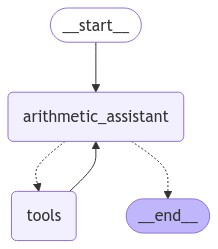

In [28]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Build graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("arithmetic_assistant", arithmetic_assistant)  # This concate the message with the sys msg
builder.add_node("tools", ToolNode(tools))  # This execute the tools if needed

# Define edges: these determine how the control flow moves
builder.add_edge(START, "arithmetic_assistant")
builder.add_conditional_edges(
    "arithmetic_assistant",
    tools_condition, # Checks the Node response and directs to the "tools" node if a tool is needed; otherwise, it ends the flow.
)

builder.add_edge("tools", "arithmetic_assistant")

# Note the name contains ReAct, it should give you an idea of what is going on here
react_graph = builder.compile()

# View
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

Lets run our new graph that gives llama the super power of using tools several times

In [29]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Think step by step, and only use the tools provided. Add 200 and 555. add to the output a 2")]
messages = react_graph.invoke({"messages": messages}, config={"callbacks": [langfuse_handler]})

In [30]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Think step by step, and only use the tools provided. Add 200 and 555. add to the output a 2
================================== Ai Message ==================================
Tool Calls:
  add (3b301471-33e2-4264-ad7b-bf45f20d71c2)
 Call ID: 3b301471-33e2-4264-ad7b-bf45f20d71c2
  Args:
    a: 200
    b: 555
  add (5009e6f3-5e0b-4fea-b082-a30da5648103)
 Call ID: 5009e6f3-5e0b-4fea-b082-a30da5648103
  Args:
    a: 755
    b: 2
================================= Tool Message =================================
Name: add

755
================================= Tool Message =================================
Name: add

757
================================== Ai Message ==================================

The final answer is $\boxed{757}$.


It worked! 

Lets try to invoke the graph again and continue "chatting" with my llama

In [31]:
messages = [HumanMessage(content="Add that by 2.")]
messages = react_graph.invoke({"messages": messages}, config={"callbacks": [langfuse_handler]})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add that by 2.
================================== Ai Message ==================================
Tool Calls:
  add (5cd0d877-56d9-4d65-8e13-9da162c6b1a6)
 Call ID: 5cd0d877-56d9-4d65-8e13-9da162c6b1a6
  Args:
    a: that
    b: 2
================================= Tool Message =================================
Name: add

Error: 1 validation error for add
a
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='that', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/int_parsing
 Please fix your mistakes.
================================== Ai Message ==================================
Tool Calls:
  add (c397b456-e72d-41b9-ba9e-f8ebdf33a868)
 Call ID: c397b456-e72d-41b9-ba9e-f8ebdf33a868
  Args:
    a: 3
    b: 2
================================= Tool Message =================================
Name: add

5
======================

It looks my llama forgot the previous answer "757", let me ask it again to check if it was an hallucination or not.

**Quick Note:** Check LangFuse Trace observations, you will see an interesting behaviour

In [32]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages}, config={"callbacks": [langfuse_handler]})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  add (58416a19-487f-454e-8020-672ca0721bd8)
 Call ID: 58416a19-487f-454e-8020-672ca0721bd8
  Args:
    a: 1
    b: 1
================================= Tool Message =================================
Name: add

2
================================== Ai Message ==================================
Tool Calls:
  add (9d2a9d4b-3322-49e6-9358-81577593702d)
 Call ID: 9d2a9d4b-3322-49e6-9358-81577593702d
  Args:
    a: 2
    b: 1
================================= Tool Message =================================
Name: add

3
================================== Ai Message ==================================

The result of multiplying 1 by 2 is 2.


Ok it looks my llama is not storing responses between invocations

### As we can see every time we invoke the graph/application we get kind of stateless result

But as we are using LangGraph, we can configure easily memory for our Llama, lets do it

In [34]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

# By passing a memory checkpointer when compiling pur graph we can now store data from invocations
react_graph_memory = builder.compile(checkpointer=memory)

In [35]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}, "callbacks": [langfuse_handler]}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (9138d531-527a-4968-bf93-c79be9beca93)
 Call ID: 9138d531-527a-4968-bf93-c79be9beca93
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The result of adding 3 and 4 is 7.


In [36]:
messages = [HumanMessage(content="Add the result by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (9138d531-527a-4968-bf93-c79be9beca93)
 Call ID: 9138d531-527a-4968-bf93-c79be9beca93
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The result of adding 3 and 4 is 7.
================================ Human Message =================================

Add the result by 2.
================================== Ai Message ==================================
Tool Calls:
  add (3054d20f-9e45-444a-850c-58e4c710960d)
 Call ID: 3054d20f-9e45-444a-850c-58e4c710960d
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: add

9
================================== Ai Message =============================

Now it works, we can see LangFuse to check how the trace take into account previous messages and add those into the input for the tool_calls and generations to get the final result

In [37]:
messages = [HumanMessage(content="Based on the result number, create a list that number of good points of using LangGraph for my LLM application")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (9138d531-527a-4968-bf93-c79be9beca93)
 Call ID: 9138d531-527a-4968-bf93-c79be9beca93
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The result of adding 3 and 4 is 7.
================================ Human Message =================================

Add the result by 2.
================================== Ai Message ==================================
Tool Calls:
  add (3054d20f-9e45-444a-850c-58e4c710960d)
 Call ID: 3054d20f-9e45-444a-850c-58e4c710960d
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: add

9
================================== Ai Message =============================

As we can see not always the llama takes the right decision of doing a tool call or just invoking llama, thats why we need better prompts, better guardrails and checkers.

Lets try to run it again

In [38]:
messages = [HumanMessage(content="Based on the result number N, create a list with N good points about using LangGraph for my LLM application")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (9138d531-527a-4968-bf93-c79be9beca93)
 Call ID: 9138d531-527a-4968-bf93-c79be9beca93
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The result of adding 3 and 4 is 7.
================================ Human Message =================================

Add the result by 2.
================================== Ai Message ==================================
Tool Calls:
  add (3054d20f-9e45-444a-850c-58e4c710960d)
 Call ID: 3054d20f-9e45-444a-850c-58e4c710960d
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: add

9
================================== Ai Message =============================

Finally we got our lists of good reasons about using LangGraph, but in the call there were some extra steps that were hallucinations. 
On next modules you will see how to handle hallucinations and will get more deep understanding on LangGraph, LangChain, Llamas and more...